# Sliding Window Cross Validation 
## Define fixed Dataset K_fold split for each trial: 

In [1]:
import sys
import os
import torch 
import numpy as np 
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from pipeline.high_level_DL_method import load_optimizer_and_scheduler
from pipeline.dl_models.full_model import full_model
from pipeline.trainer import Trainer
from examples.train_model_on_k_fold_validation import load_configuration
from pipeline.K_fold_validation.K_fold_validation import KFoldSplitter


/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


No module xgboost
Training and Hyper-parameter tuning with Ray is not possible


In [2]:
#trial_id = 'subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
trial_id = 'subway_in_subway_out_calendar_STGformer_MSELoss_2025_05_03_04_19_34322'
#trial_id = 'subway_in_calendar_netmob_POIs_STAEformer_HuberLossLoss_2025_06_11_21_33_4901'
args,_ = load_configuration(trial_id,load_config=True)
if not hasattr(args,'horizon_step'):
    args.horizon_step = 1
args.K_fold = 6

folds =  list(np.arange(args.K_fold))
K_fold_splitter = KFoldSplitter(args,folds)
K_subway_ds,args = K_fold_splitter.split_k_fold()


>>>> Load best CONFIG
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2821, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([940, 40, 7])

>>>Loading calendar inputs ...

>>>Tackle Contextual dataset:  subway_out
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_out/subway_out.csv


Restraining all datasets to train common dates: 2821 dates
Restraining all datasets to valid common dates: 940 dates
Restraining all datasets to test common dates: 940 dates

Size of Contextual datasets:
   Init Dataset: '[torch.Size([7392, 40])]
   TRAIN

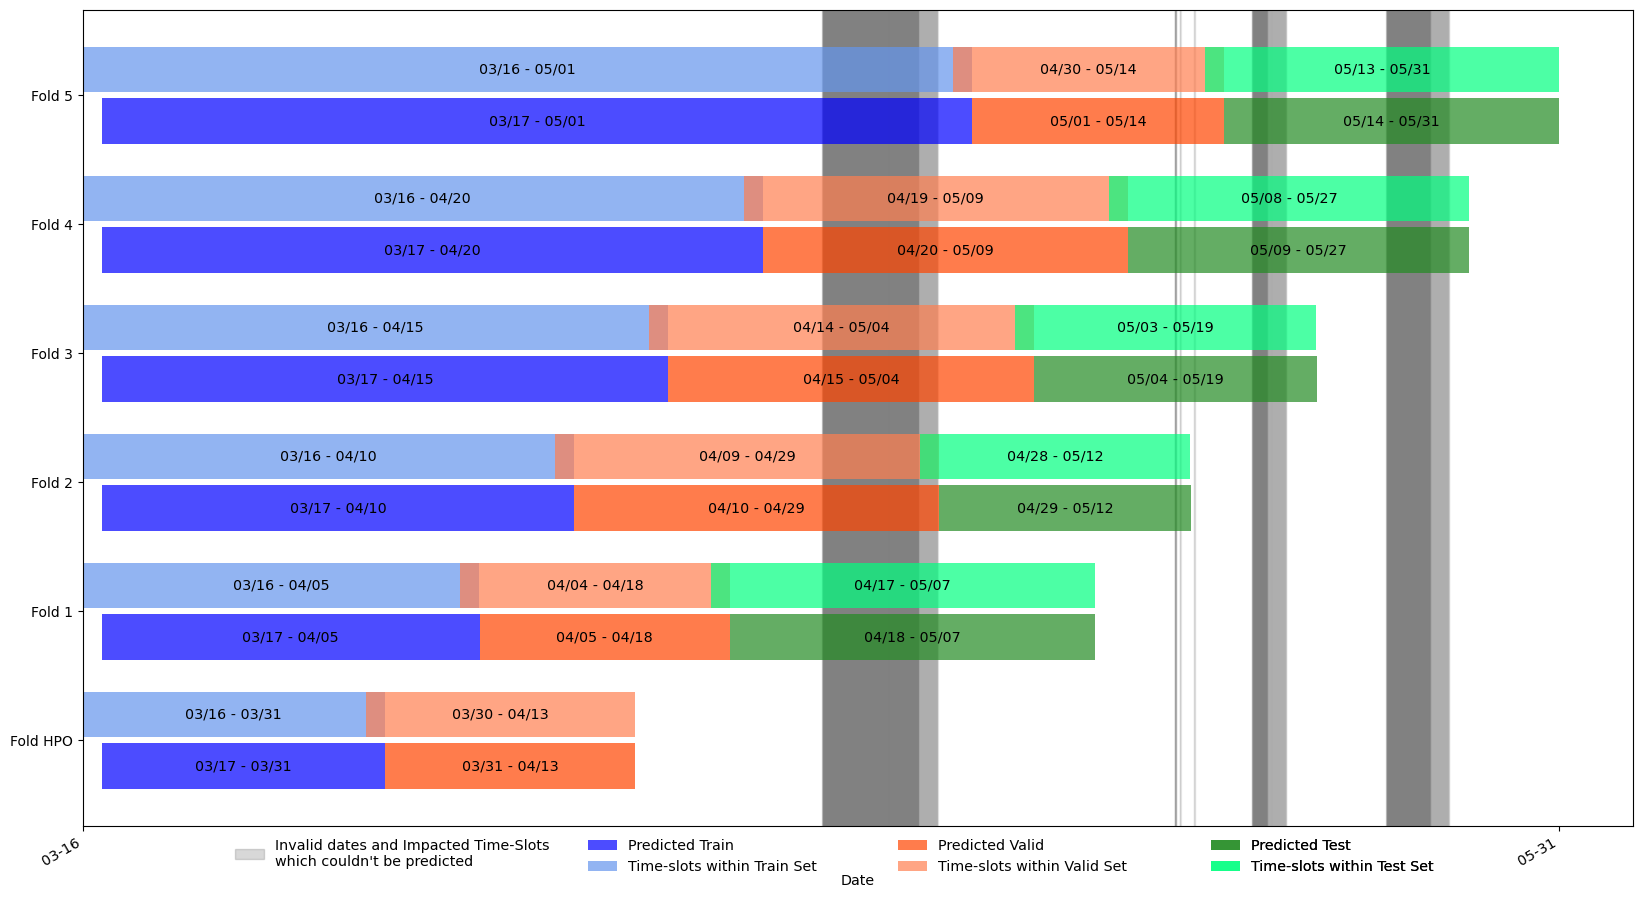

In [ ]:
from plotting.plotting import plot_k_fold_split


plot_k_fold_split(K_subway_ds,K_subway_ds[0].init_invalid_dates,figsize=(20,12),hpo = True)


In [11]:
from examples.benchmark import local_get_args
dataset_for_coverage = ['subway_in','netmob_POIs'] 
model_name = 'STGCN'
modification  = {'ray':False,
                 'use_target_as_context': False,

                'batch_size':128,
                'step_ahead':4,

                'evaluate_complete_ds' : True,
                'torch_compile':False,

                'temporal_graph_transformer_encoder': False, # False # True
                'need_global_attn' : False, # False # True

                'data_augmentation': True, #True,  #False
                'DA_method':'rich_interpolation', # 'noise' # 'interpolation


                 'target_data': 'subway_in',
                'dataset_names': ['subway_in', 'calendar_embedding'],
                'embedding_calendar_types': ['dayofweek', 'hour'],
                'loss_function_type':'HuberLoss',
                'Kt': 2,
                'stblock_num': 4,
                'Ks': 2,
                'graph_conv_type': 'graph_conv',
                'gso_type': 'sym_renorm_adj',
                'enable_bias': True,
                'adj_type': 'corr',
                'enable_padding': True,
                'threshold': 0.3,
                'act_func': 'glu',
                'temporal_h_dim': 64,
                'spatial_h_dim': 256,
                'output_h_dim': 64,
                'weight_decay': 0.0014517707449388,
                'batch_size': 128,
                'lr': 0.00071,
                'dropout': 0.145169206052754,
                'epochs': 500,
                'standardize': False,
                'minmaxnorm': True,
                'K_fold':6,

                'TE_embedding_dim': 64,
                'TE_out_h_dim': 64,
                'TE_concatenation_late': True,
                'TE_concatenation_early':False,
                 'num_workers' : 4, # 0,1,2, 4, 6, 8 ... A l'IDRIS ils bossent avec 6 num workers par A100 80GB
                'persistent_workers' : True ,# False 
                'pin_memory' : True ,# False 
                'prefetch_factor' : 4, # None, 2,3,4,5 ... 
                'drop_last' : False,  # True
                'mixed_precision' : False, # True # False
                'torch_compile' : 'compile' , # 'compile' # 'jit_script' #'trace' # False
                'unormalize_loss' : True, # False

                'device': torch.device('cuda:1')
                }


args = local_get_args(model_name,
                    args_init = None,
                    dataset_names=modification['dataset_names'],
                    dataset_for_coverage=dataset_for_coverage,
                    modification =modification
                    )

folds =  list(np.arange(args.K_fold))
K_fold_splitter = KFoldSplitter(args,folds)
K_subway_ds,_ = K_fold_splitter.split_k_fold()
ds_validation = K_subway_ds[1:]


valid_losses = {}
for fold,ds in enumerate(ds_validation):
    model = full_model(ds, args).to(args.device)
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
    trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler,show_figure = False,trial_id = None, fold=fold)
    trainer.train_and_valid(normalizer = ds.normalizer, mod = 1000,mod_plot = None) 
    valid_losses[fold] = trainer.valid_loss

----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2819, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([939, 40, 7])

 Loading calendar embedding inputs ...
dict_keys(['dayofweek_OHE', 'hour_OHE'])
args_embedding.variable_selection_model_name:  MLP
2819 train samples had been added thank to Data Augmentation
calendar data augmented by dupplication but not modified
Train/Target size:  torch.Size([5638, 40, 7]) torch.Size([5638, 40, 4])
Init U/Utarget size: torch.Size([4699, 40, 7])/torch.Size([4699, 40, 4]) Train/Valid/Test 5638 940 939

------------------------------

[2025-06-16 15:39:24,765] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-16 15:39:30,750] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epoch: 1     Train Loss: 99.78058208781442 Val Loss: 59.41817558775557
epoch: 1 
 min\epoch : 0.01
Estimated time for training: 5.5min 
Epoch: 3     Train Loss: 51.90517643134137 Val Loss: 36.899566195873504
Epoch: 56     Train Loss: 26.198324723186346 Val Loss: 26.526934717056598
Epoch: 112     Train Loss: 23.618813476238532 Val Loss: 25.861219690201132
Epoch: 167     Train Loss: 22.344934082841164 Val Loss: 26.031102298168427
Epoch: 223     Train Loss: 21.350849142162325 Val Loss: 25.584949688201256
Epoch: 278     Train Loss: 20.64204471261469 Val Loss: 25.462603532507064
Epoch: 334     Train Loss: 19.969555073904804 Val Loss: 25.259023382308634
Epoch: 389     Train Loss: 19.382935009016183 Val Loss: 25.679765157496675
Epoch: 445     Train Loss: 18.859627940345973 Val Loss: 25.705557104881773
Epoch: 500     Train Loss: 18.642163313793443 Val Loss: 25.972692416576628

Training Throughput:3337.82 sequences per seconds
>>> Training complete in: 0:04:35.909098
>>> Training (62.97%) perfo

[2025-06-16 15:44:01,265] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-16 15:44:06,410] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epoch: 1     Train Loss: 98.44278772401701 Val Loss: 48.42352689377805
epoch: 1 
 min\epoch : 0.01
Estimated time for training: 5.7min 
Epoch: 3     Train Loss: 51.36708113828214 Val Loss: 32.53560055671854
Epoch: 56     Train Loss: 25.049200222335436 Val Loss: 26.14742400798392
Epoch: 112     Train Loss: 22.914034512578226 Val Loss: 26.607636894063745
Epoch: 167     Train Loss: 21.659521176431184 Val Loss: 26.230233975674242
Epoch: 223     Train Loss: 20.346900749639047 Val Loss: 26.08413706028715
Epoch: 278     Train Loss: 19.476448387786103 Val Loss: 26.035160843869473
Epoch: 334     Train Loss: 18.744961022790058 Val Loss: 26.52924241410925
Epoch: 389     Train Loss: 18.158923609727093 Val Loss: 26.252658486873546
Epoch: 445     Train Loss: 17.714582568663857 Val Loss: 26.714021690855635
Epoch: 500     Train Loss: 17.2564970219757 Val Loss: 26.601468463654214

Training Throughput:3959.51 sequences per seconds
>>> Training complete in: 0:04:45.034452
>>> Training (62.20%) performanc

[2025-06-16 15:48:45,898] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-16 15:48:51,795] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-16 15:48:59,926] torch._dynamo.convert_frame: [WARNING] torch._dynamo hit config.cache_size_limit (64)
   function: 'forward' (/home/rrochas/prediction-validation/dl_models/full_model.py:411)
   reasons:  ___guarded_code.valid
to diagnose recompilation issues, see https://pytorch.org/docs/master/dynamo/troubleshooting.html.


Epoch: 1     Train Loss: 92.03375958788209 Val Loss: 58.917494526315245


[2025-06-16 15:49:06,547] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-16 15:49:09,899] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-16 15:49:19,691] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-16 15:49:22,284] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


epoch: 1 
 min\epoch : 0.51
Estimated time for training: 6.6min 
Epoch: 3     Train Loss: 46.51249086851211 Val Loss: 38.303066148149206
Epoch: 56     Train Loss: 25.109750575595832 Val Loss: 27.192620626409003
Epoch: 112     Train Loss: 22.539809739189888 Val Loss: 27.78150660738032
Epoch: 167     Train Loss: 21.343402683256254 Val Loss: 25.964192646107776
Epoch: 223     Train Loss: 20.257315849660984 Val Loss: 26.530244778572246
Epoch: 278     Train Loss: 19.418958650425914 Val Loss: 25.78191421184134
Epoch: 334     Train Loss: 19.048443898312257 Val Loss: 26.38771538024253
Epoch: 389     Train Loss: 18.359854782421632 Val Loss: 25.89928281662312
Epoch: 445     Train Loss: 17.819088668715125 Val Loss: 26.23462117377748
Epoch: 500     Train Loss: 17.35274063960865 Val Loss: 26.054768221429054

Training Throughput:3869.30 sequences per seconds
>>> Training complete in: 0:05:48.926971
>>> Training (57.40%) performance time: min 0.01 avg 1.30e-02 seconds (+/- 1.66e-01)
>>> Loading (40.00

[2025-06-16 15:54:32,500] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-16 15:54:34,920] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-16 15:54:38,518] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-16 15:54:41,188] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epoch: 1     Train Loss: 94.6673911516847 Val Loss: 54.6858460608949
epoch: 1 
 min\epoch : 0.01
Estimated time for training: 6.9min 
Epoch: 3     Train Loss: 46.21035244378932 Val Loss: 38.75424856632314
Epoch: 56     Train Loss: 24.352640112579085 Val Loss: 23.441701913387217
Epoch: 112     Train Loss: 21.995103202594247 Val Loss: 22.719751228170193
Epoch: 167     Train Loss: 20.67144997026236 Val Loss: 23.600798854422063
Epoch: 223     Train Loss: 19.725733763585453 Val Loss: 22.702379299731966
Epoch: 278     Train Loss: 18.981396030443022 Val Loss: 23.06336870396391
Epoch: 334     Train Loss: 18.36657541645061 Val Loss: 23.272355440829664
Epoch: 389     Train Loss: 17.849988911884815 Val Loss: 23.255159524146546
Epoch: 445     Train Loss: 17.461998500337288 Val Loss: 23.610586807575633
Epoch: 500     Train Loss: 17.136909907431 Val Loss: 23.431517548256732

Training Throughput:3986.78 sequences per seconds
>>> Training complete in: 0:06:17.535936
>>> Training (62.73%) performance t

[2025-06-16 16:00:50,140] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-16 16:00:52,578] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-16 16:00:56,498] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-16 16:00:59,179] torch._inductor.utils: [WARNING] using triton random, expect difference from eager


Epoch: 1     Train Loss: 74.83420986704643 Val Loss: 46.11737860821663
epoch: 1 
 min\epoch : 0.02
Estimated time for training: 7.8min 
Epoch: 3     Train Loss: 39.26942763678695 Val Loss: 35.868337265988615
Epoch: 56     Train Loss: 24.629412742065345 Val Loss: 22.932976442702273
Epoch: 112     Train Loss: 21.75390773717712 Val Loss: 22.323986938151908
Epoch: 167     Train Loss: 20.576625454548445 Val Loss: 21.297528766063934
Epoch: 223     Train Loss: 19.910151422425507 Val Loss: 21.50254277168436
Epoch: 278     Train Loss: 18.900347305384457 Val Loss: 20.909983468563
Epoch: 334     Train Loss: 18.53037281449106 Val Loss: 21.51170242796553
Epoch: 389     Train Loss: 17.94702305409789 Val Loss: 21.189595908307016
Epoch: 445     Train Loss: 17.573271454036046 Val Loss: 21.107364313653175
Epoch: 500     Train Loss: 17.115316183950174 Val Loss: 21.851189503771195

Training Throughput:3584.84 sequences per seconds
>>> Training complete in: 0:07:46.964432
>>> Training (63.94%) performance 

In [14]:
trainer.performance['test_metrics']

{'rmse_h1': 36.6644401550293,
 'mse_h1': 1344.2811279296875,
 'mae_h1': 20.78801918029785,
 'mape_h1': 23.523773193359375,
 'mase_h1': 0.649253785610199,
 'rmse_h2': 38.648799896240234,
 'mse_h2': 1493.729736328125,
 'mae_h2': 21.719135284423828,
 'mape_h2': 24.78978729248047,
 'mase_h2': 0.6803005933761597,
 'rmse_h3': 40.433231353759766,
 'mse_h3': 1634.8460693359375,
 'mae_h3': 22.36639404296875,
 'mape_h3': 26.216073989868164,
 'mase_h3': 0.7017619013786316,
 'rmse_h4': 41.14872741699219,
 'mse_h4': 1693.2176513671875,
 'mae_h4': 22.546812057495117,
 'mape_h4': 28.601444244384766,
 'mase_h4': 0.7048808336257935,
 'rmse_all': 39.22379970550537,
 'mse_all': 1541.5186462402344,
 'mae_all': 21.855090141296387,
 'mape_all': 25.782769680023193,
 'mase_all': 0.6840492784976959}

In [ ]:
from bokeh.models import Span,HBar
from bokeh.plotting import figure
from bokeh.models import Legend,DatetimeTickFormatter

from bokeh.palettes import Turbo256 as palette
from bokeh.layouts import column
from bokeh.plotting import output_notebook,show
import numpy as np 
import pandas as pd

losses = pd.DataFrame(valid_losses)
losses.columns = [f'f{k}_valid_loss' for k in losses.columns]


k = 0
dic ={}
for k in [0,1,2,3,4]:
    s = losses[f'f{k}_valid_loss'].copy()
    mini = s.min()
    index_mini = list(s.values).index(mini)
    dic[k] = {'idx':index_mini, 'value':mini}



width = 1200
height = 400
title = 'Losses through epochs'

p = figure(title=title,width=width,height=height)
legend_it = []
colors = palette
list_df_ts = [losses[[c for c in losses.columns if not 'train' in c and not 'complete' in c]].copy()]


nb_cols = [df_i.shape[1] for df_i in list_df_ts]
total_nb_ts = int(np.sum(np.array(nb_cols)))
for i,df_i in enumerate(list_df_ts):
        for k,column_i in enumerate(df_i.columns):
                col_ind = np.sum(np.array(nb_cols[:i]))+k
                c = p.line(x=df_i.index, y=df_i[column_i], alpha=0.8,color = colors[int(col_ind*(255/total_nb_ts))])
                str_old = column_i[1]
                str_new = str(int(column_i[1])+1)
                column_i = column_i.replace(str_old,str_new)

                displayed_legend = str(column_i)
                legend_it.append((displayed_legend, [c]))

                epoch = dic[k]['idx']
                value = dic[k]['value']
                #p.line(x = [0,epoch],y = [value,value], line_color = colors[int(col_ind*(255/total_nb_ts))],line_dash = 'dashed')
                p.line(x = [epoch,epoch],y = [value,1e3], line_color = colors[int(col_ind*(255/total_nb_ts))],line_dash = 'dashed')
                p.circle(x = epoch,y = value, size = 10, color = colors[int(col_ind*(255/total_nb_ts))],legend_label=displayed_legend)

p.xaxis.major_label_orientation = 1.2  # Pour faire pivoter les labels des x
legend = Legend(items=legend_it)
legend.click_policy="hide"
p.add_layout(legend, 'right')


output_notebook()
show(p)

trainer.performance['test_metrics']


### STAEformer with DA

Loading BokehJS ...

{'rmse_h1': 37.513938903808594,
 'mse_h1': 1407.2955322265625,
 'mae_h1': 21.50118064880371,
 'mape_h1': 23.696035385131836,
 'mase_h1': 0.6714960336685181,
 'rmse_h2': 40.48769760131836,
 'mse_h2': 1639.253662109375,
 'mae_h2': 23.115564346313477,
 'mape_h2': 26.258241653442383,
 'mase_h2': 0.7241841554641724,
 'rmse_h3': 42.855953216552734,
 'mse_h3': 1836.632568359375,
 'mae_h3': 24.2139835357666,
 'mape_h3': 28.075382232666016,
 'mase_h3': 0.7598844170570374,
 'rmse_h4': 44.48765182495117,
 'mse_h4': 1979.1510009765625,
 'mae_h4': 24.674312591552734,
 'mape_h4': 29.757347106933594,
 'mase_h4': 0.7714148163795471,
 'rmse_all': 41.336310386657715,
 'mse_all': 1715.5831909179688,
 'mae_all': 23.37626028060913,
 'mape_all': 26.946751594543457,
 'mase_all': 0.7317448556423187}

In [ ]:
### STAEformer no DA

Loading BokehJS ...

{'rmse_h1': 38.03689193725586,
 'mse_h1': 1446.80517578125,
 'mae_h1': 21.738643646240234,
 'mape_h1': 23.881013870239258,
 'mase_h1': 0.6789646744728088,
 'rmse_h2': 40.804100036621094,
 'mse_h2': 1664.974609375,
 'mae_h2': 23.39862823486328,
 'mape_h2': 26.463226318359375,
 'mase_h2': 0.7325466275215149,
 'rmse_h3': 42.11727523803711,
 'mse_h3': 1773.864990234375,
 'mae_h3': 24.252958297729492,
 'mape_h3': 28.470420837402344,
 'mase_h3': 0.7610482573509216,
 'rmse_h4': 44.4516487121582,
 'mse_h4': 1975.9490966796875,
 'mae_h4': 25.06658363342285,
 'mape_h4': 31.23756980895996,
 'mase_h4': 0.7835338711738586,
 'rmse_all': 41.352478981018066,
 'mse_all': 1715.3984680175781,
 'mae_all': 23.614203453063965,
 'mape_all': 27.513057708740234,
 'mase_all': 0.739023357629776}

In [ ]:
### STGCN with DA rich_interpolation

Loading BokehJS ...

In [ ]:
### STGCN without DA rich_interpolation

Loading BokehJS ...

In [22]:
from examples.benchmark import local_get_args
dataset_for_coverage = ['subway_in','netmob_POIs'] 
model_name = 'STAEformer'
modification  = {'ray':False,
                 'dataset_names': ['subway_in','calendar','netmob_POIs'],
                'unormalize_loss' : True,
                'contextual_kwargs' : {'netmob_POIs': {'need_global_attn':True, 
                                                        'stacked_contextual': True,
                                                        'NetMob_selected_apps' : ['Deezer','Google_Maps'], # Google_Maps # 
                                                        'NetMob_transfer_mode' :  ['DL'], #,'UL'] # ['DL'] # ['UL'] #['DL','UL']
                                                        'NetMob_selected_tags' : ['iris'],#['iris','stadium','station','university']#['park','stadium','university','station','shop','nightclub','parkings','theatre','iris','transit','public_transport']
                                                        'NetMob_expanded' : '', # '' # '_expanded'
                                                        'NetMob_only_epsilon': False, # if True then look at NetMob data in InputsEpsilon instead of Input:  '/POIs/netmob_POI_Lyon{args.NetMob_expanded}/InputsEpsilon/{id_station}'
                                                        'vision_model_name' : None,
                                                        'use_only_for_common_dates': False, # If True then only use the dataset to restrain Feature vector to the common dates between the datasets
                                                        'attn_kwargs': {'latent_dim' : 2 ,
                                                                        'dim_feedforward' : 64,
                                                                        'num_heads' : 2 ,
                                                                        'dim_model' : 12,}  
                                                        #'H' : ,
                                                        #'D': ,
                                                        #'W': , 
                                                },
                                        },  
                'denoising_names':['netmob_POIs'],
                'denoiser_names':["exponential"],   # ['median'], ['exponential'], ['savitzky_golay']         # un seul filtre
                'denoising_modes':["train","valid","test"],             # par défaut
                'denoiser_kwargs':{'exponential': {'alpha': 0.8}}, # {'savitzky_golay': {'window': 5, 'poly': 2}} # {'exponential': {'alpha':0.3}} # {"median": {"kernel_size": 2}}




                'target_data' :'subway_in',
                'use_target_as_context': False,
                'epochs':300,
                'batch_size':128,
                'grace_period':20,#20,
                'step_ahead':4,

                'evaluate_complete_ds' : False,
                'torch_compile':False,

                'temporal_graph_transformer_encoder': False, # False # True
                'need_global_attn' : False, # False # True

                'data_augmentation': True, #True,  #False
                'DA_method':'rich_interpolation', # 'noise' # 'interpolation

                'K_fold': 6,
                
                'loss_function_type':'HuberLoss',
                'optimizer': 'adamw',
                'adaptive_embedding_dim': 32,
                'input_embedding_dim': 24,
                'tod_embedding_dim': 6,
                'dow_embedding_dim': 6,
                'feed_forward_dim': 256,
                
                'num_heads': 4,
                'num_layers': 3,

                'use_mixed_proj': True,
                'freq': '15min',
                'H':6,
                'D':1,
                'W':0,

                'lr': 0.001,
                'weight_decay':  0.0015,
                'dropout': 0.2,
                'torch_scheduler_milestone': 20,
                'torch_scheduler_gamma':0.9925,
                'torch_scheduler_type': 'warmup',
                'torch_scheduler_lr_start_factor': 0.3,

}
      
args = local_get_args(model_name,
                    args_init = None,
                    dataset_names=modification['dataset_names'],
                    dataset_for_coverage=dataset_for_coverage,
                    modification =modification
                    )

args.calendar_types = ['dayofweek', 'timeofday']

folds =  list(np.arange(args.K_fold))
K_fold_splitter = KFoldSplitter(args,folds)
K_subway_ds,_ = K_fold_splitter.split_k_fold()
ds_validation = K_subway_ds[1:]


valid_losses = {}
for fold,ds in enumerate(ds_validation):
    model = full_model(ds, args).to(args.device)
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
    trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler,show_figure = False,trial_id = None, fold=fold)
    trainer.train_and_valid(normalizer = ds.normalizer, mod = 1000,mod_plot = None) 
    valid_losses[fold] = trainer.valid_loss

----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2819, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([939, 40, 7])

 Loading calendar inputs ...

>>>Tackle Contextual dataset:  netmob_POIs
Netmob_T.size():  torch.Size([7392, 860])
Restraining all datasets to train common dates: 2819 dates
Restraining all datasets to valid common dates: 940 dates
Restraining all datasets to test common dates: 939 dates
kwargs_i: {'need_global_attn': True, 'stacked_contextual': True, 'NetMob_selected_apps': ['Deezer', 'Google_Maps'], 'NetMob_transfer_mode': ['DL'], 'NetMob_selected_t

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 34     Train Loss: 28.629270291716516 Val Loss: 28.181270079917095
Epoch: 67     Train Loss: 25.21831512451172 Val Loss: 29.338707830550824
Epoch: 101     Train Loss: 23.259305490978374 Val Loss: 26.522252427770738
Epoch: 134     Train Loss: 21.986434524816904 Val Loss: 27.501608795815326
Epoch: 167     Train Loss: 21.319218709126314 Val Loss: 25.306605481086894
Epoch: 201     Train Loss: 20.40885199744568 Val Loss: 25.665308428825217
Epoch: 234     Train Loss: 19.753837056305084 Val Loss: 25.888676063050614
Epoch: 267     Train Loss: 19.34469682243979 Val Loss: 25.26867612473508
Epoch: 300     Train Loss: 19.109451269647877 Val Loss: 25.498498129337392

Training Throughput:1415.52 sequences per seconds
>>> Training complete in: 0:06:14.605898
>>> Training (58.86%) performance time: min 0.03 avg 4.35e-02 seconds (+/- 4.79e-03)
>>> Loading (37.17%) performance time: min 0.00 avg 2.68e-02 seconds (+/- 5.67e-02)
>>> Forward  (21.64%) performance time: 1.60e-02 seconds (+/- 2.11e-03

/tmp/ipykernel_44783/335097983.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(start=serie.min(), end=serie.max(), freq=freq)
/tmp/ipykernel_44783/335097983.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(start=serie.min(), end=serie.max(), freq=freq)
/tmp/ipykernel_44783/335097983.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(start=serie.min(), end=serie.max(), freq=freq)
/tmp/ipykernel_44783/335097983.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_index = pd.date_range(start=serie.min(), end=serie.max(), freq=freq)
/tmp/ipykernel_44783/335097983.py:23: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full

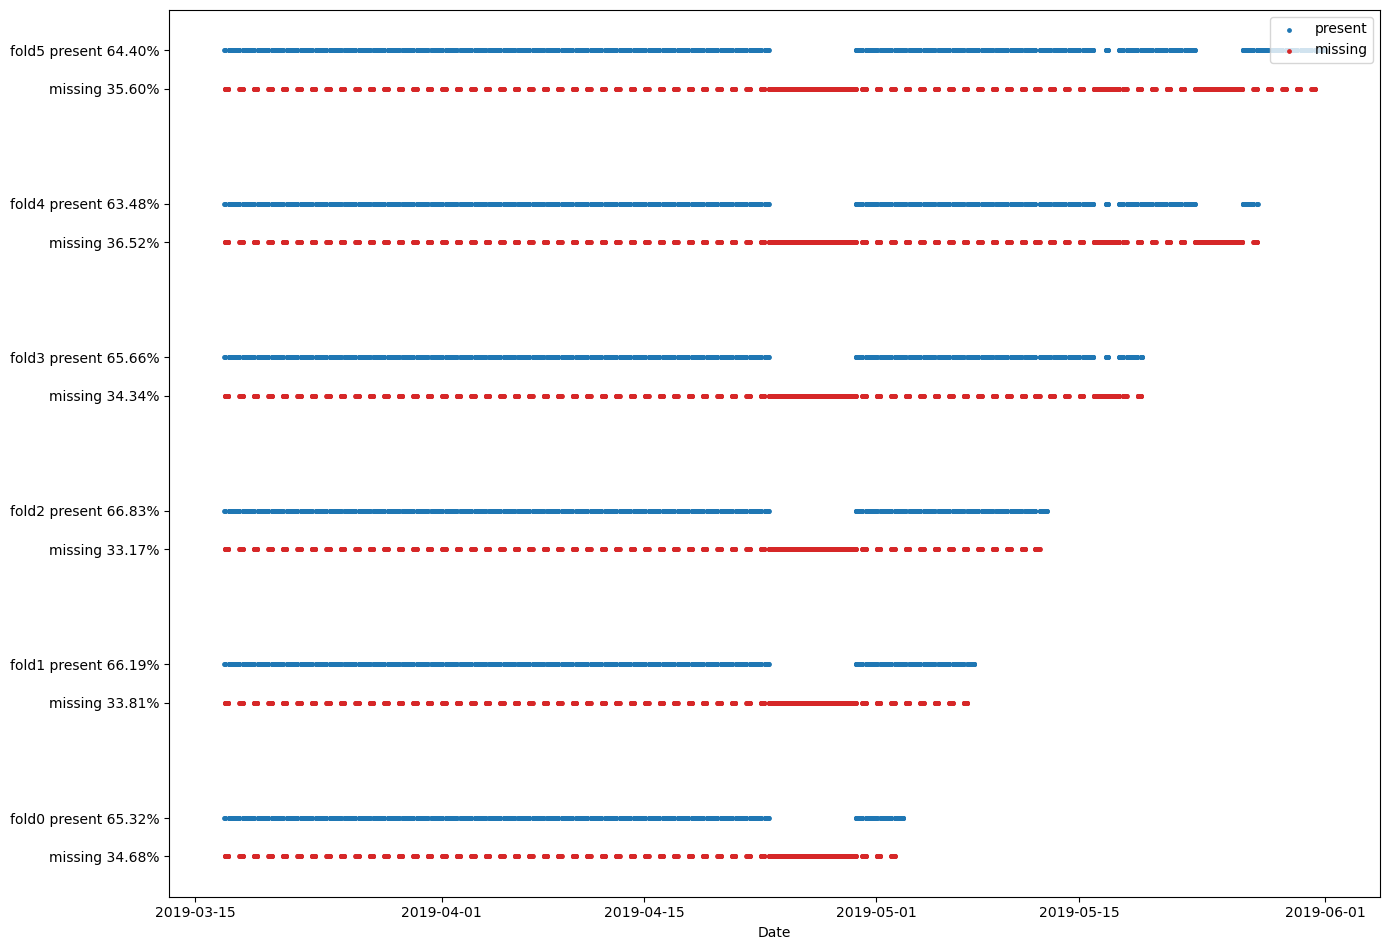

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_missing_dates_folds(K_subway_ds, freq='15T'):
    """
    Affiche, pour chaque fold, les instants présents et manquants sur un seul graphique.
    Axe vertical : fold0 present, fold0 missing, fold1 present, fold1 missing, …
    """
    fig, ax = plt.subplots(figsize=(14, 1.6 * len(K_subway_ds)))
    y_ticks, y_labels = [], []

    for i, subway_ds in enumerate(K_subway_ds):
        # Extraction des timestamps de chaque split
        s_train = pd.to_datetime(subway_ds.tensor_limits_keeper.df_verif_train.iloc[:, -1])
        s_valid = pd.to_datetime(subway_ds.tensor_limits_keeper.df_verif_valid.iloc[:, -1])
        s_test  = pd.to_datetime(subway_ds.tensor_limits_keeper.df_verif_test.iloc[:,  -1])

        serie = pd.concat([s_train, s_valid, s_test]).dropna().sort_values()

        if serie.empty:
            continue  # sécurité si un fold est vide

        full_index = pd.date_range(start=serie.min(), end=serie.max(), freq=freq)
        present_mask = full_index.isin(serie)

        y_missing= 4 * i
        y_present= 4 * i + 1
        y_ticks.extend([y_present, y_missing])
        y_labels.extend([f"fold{i} present {'{:.2%}'.format(len(serie)/len(full_index))}", f"missing {'{:.2%}'.format(1-len(serie)/len(full_index))}"])

        ax.scatter(full_index[present_mask], [y_present] * present_mask.sum(),
                   c='tab:blue', s=6, label=f"present" if i == 0 else None)
        ax.scatter(full_index[~present_mask], [y_missing] * (~present_mask).sum(),
                   c='tab:red', s=6, label=f"missing" if i == 0 else None)

    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel('Date')
    ax.legend(loc='upper right', markerscale=1)
    plt.tight_layout()
    plt.show()

plot_missing_dates_folds(K_subway_ds, freq='15T')

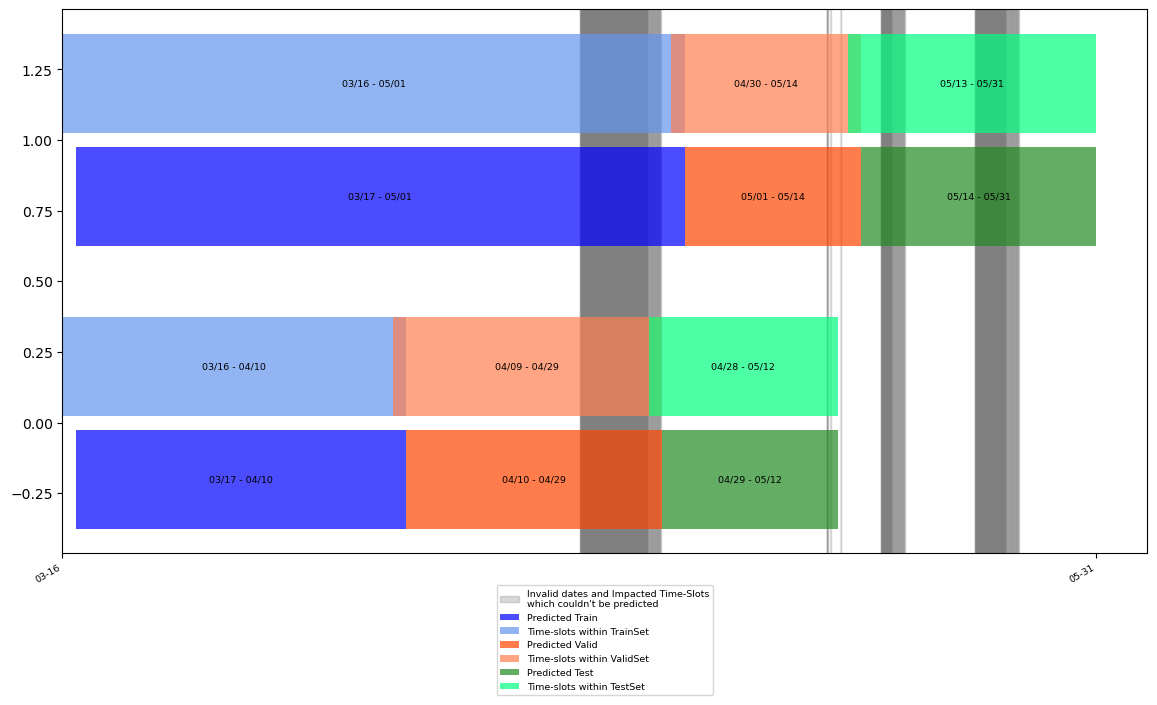

In [15]:
from plotting.plotting import plot_k_fold_split
plot_k_fold_split(K_subway_ds,K_subway_ds[0].init_invalid_dates,figsize=(14,8),save_path = '../save/plot/2_fold_split.pdf')

## Train on the K-1 folds:

In [16]:
trial_id = 'subway_in_calendar_netmob_POIs_STAEformer_HuberLossLoss_2025_06_11_21_33_4901'
args,_ = load_configuration(trial_id,load_config=True)
folds =  list(np.arange(args.K_fold))
K_fold_splitter = KFoldSplitter(args,folds)
K_subway_ds,args = K_fold_splitter.split_k_fold()

## Split the dataset already used for HP tuning and the others: 
ds_tuning = K_subway_ds[0]
ds_validation = K_subway_ds[1:]

## K-fold validation:
valid_losses = []
for fold,ds in enumerate(ds_validation):
    model = full_model(ds, args).to(args.device)
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
    trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler,show_figure = False,trial_id = trial_id, fold=0)
    trainer.train_and_valid(normalizer = ds.normalizer, mod = 1000,mod_plot = None) 
    valid_losses.append(trainer.performance['valid_loss'])

## Save Model: 
if False:
    row = {f"fold{k}": [loss] for k,loss in enumerate(valid_losses)}
    row.update({'mean' : [np.mean(valid_losses)]})
    df_results = pd.DataFrame.from_dict(row)
    df_results.to_csv(f"{SAVE_DIRECTORY}/{save_folder}/VALID_{trial_id}.csv")


>>>> Load best CONFIG
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2819, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([939, 40, 7])

 Loading calendar inputs ...

>>>Tackle Contextual dataset:  netmob_POIs
Netmob_T.size():  torch.Size([7392, 860])
Restraining all datasets to train common dates: 2819 dates
Restraining all datasets to valid common dates: 940 dates
Restraining all datasets to test common dates: 939 dates
kwargs_i: {'need_global_attn': True, 'stacked_contextual': True, 'NetMob_selected_apps': ['Deezer', 'Google_Maps'], 'NetMob_transfer_mode': ['D

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1     Train Loss: 277.4002420047193 Val Loss: 117.0522017783307
epoch: 1 
 min\epoch : 0.02
Estimated time for training: 9.8min 
Epoch: 3     Train Loss: 76.2338582797015 Val Loss: 107.24433541805186
Epoch: 56     Train Loss: 25.498766420411066 Val Loss: 30.548246286270466
Epoch: 112     Train Loss: 23.625290691704564 Val Loss: 28.206124666903882
Epoch: 167     Train Loss: 22.961478848032765 Val Loss: 27.458827022795983
Epoch: 223     Train Loss: 22.63186373445065 Val Loss: 27.199834279811128
Epoch: 278     Train Loss: 22.536769197781318 Val Loss: 27.100553041823368
Epoch: 334     Train Loss: 22.498534209680034 Val Loss: 27.019203794763442
Epoch: 389     Train Loss: 22.461853166724318 Val Loss: 27.00389513056329
Epoch: 445     Train Loss: 22.45287589377315 Val Loss: 27.002329952158828
Epoch: 500     Train Loss: 22.457172387709385 Val Loss: 27.007735329485953

Training Throughput:3314.75 sequences per seconds
>>> Training complete in: 0:09:04.218369
>>> Training (59.94%) performa

In [17]:
trainer.performance['test_metrics']['rmse_all'],trainer.performance['test_metrics']['mae_all'],trainer.performance['test_metrics']['mse_all'],

(41.352478981018066, 23.614203453063965, 1715.3984680175781)

In [21]:
trainer.performance['test_metrics']['rmse_all'],trainer.performance['test_metrics']['mae_all'],trainer.performance['test_metrics']['mse_all'],

(41.33493518829346, 23.92946147918701, 1712.2852783203125)

In [24]:
modification = { 'target_data': 'subway_in',
    'dataset_names': ['subway_in', 'calendar', 'netmob_POIs'],
 'dataset_for_coverage': ['subway_in', 'netmob_POIs'],
 'calendar_types': ['dayofweek', 'timeofday'],
 'embedding_calendar_types': ['dayofweek', 'hour', 'minute'],
 'optimizer': 'adamw',
 'loss_function_type': 'HuberLoss',
 'freq': '15min',
 'minmaxnorm': True,
 'standardize': False,
 'learnable_adj_matrix': False,

 'quick_vision': False,
 'evaluate_complete_ds': True,
 'train_valid_test_split_method': 'similar_length_method',
 'set_spatial_units': None,
 'hp_tuning_on_first_fold': True,
 'keep_best_weights': False,
 'num_workers': 0,
 'persistent_workers': False,
 'pin_memory': True,
 'prefetch_factor': 2,
 'drop_last': False,
 'mixed_precision': True,
 'non_blocking': True,
 'torch_compile': 'compile',#False,
 'backend': 'inductor',
 'prefetch_all': False,

 'denoising_names': ['netmob_POIs'],
 'denoiser_names': ['exponential'],
 'denoising_modes': ['train', 'valid', 'test'],
 'denoiser_kwargs': {'exponential': {'alpha': 0.8}},

 'contextual_kwargs': {'netmob_POIs': {'need_global_attn': True,
                        'stacked_contextual': True,
                        'NetMob_selected_apps': ['Deezer', 'Google_Maps'],
                        'NetMob_transfer_mode': ['DL'],
                        'NetMob_selected_tags': ['iris'],
                        'NetMob_expanded': '',
                        'NetMob_only_epsilon': False,
                        'vision_model_name': None,
                        'use_only_for_common_dates': False,
                        'attn_kwargs': {'latent_dim': 2,
                            'dim_feedforward': 64,
                            'num_heads': 2,
                            'dim_model': 64},   
                        },
 },
 'ray': False,
 'data_augmentation': False,
 'H': 6,
 'W': 0,
 'D': 1,
 'step_ahead': 4,
 'horizon_step': 1,
 'L': 7,
 'shuffle': True,
 'train_prop': 0.6,
 'calib_prop': None,
 'valid_prop': 0.2,
 'test_prop': 0.19999999999999996,
 'track_pi': False,
 'validation_split_method': 'forward_chaining_cv',
 'min_fold_size_proportion': 0.75,
 'no_common_dates_between_set': False,
 'K_fold': 2,
 'current_fold': 0,
 'metrics': ['rmse', 'mse', 'mae', 'mape', 'mase'],
 'abs_path': '/home/rrochas/prediction-validation/',
 'out_dim_factor': 1,
 'temporal_graph_transformer_encoder': False,


 'input_embedding_dim': 24,
 'tod_embedding_dim': 6,
 'dow_embedding_dim': 6,
 'spatial_embedding_dim': 0,
 'adaptive_embedding_dim': 32,
 'num_heads': 4,
 'num_layers': 3,
 'feed_forward_dim': 256,
 'use_mixed_proj': True,

 'batch_size': 128,
   
      

  'weight_decay': 0.0019180662821482,  # 'weight_decay':  0.0015,
  'lr': 0.0009241967812616,               # 'lr': 0.001,
 'dropout': 0.05,          # 'dropout': 0.2,
 'epochs': 500,
 'scheduler': True,
 'torch_scheduler_milestone': 1, # 'torch_scheduler_milestone': 20,
 'torch_scheduler_gamma': 0.9816450698678711,     # 'torch_scheduler_gamma':0.9925,
 'torch_scheduler_lr_start_factor': 0.4123017434871985,    # 'torch_scheduler_lr_start_factor': 0.3,
 'torch_scheduler_type': 'warmup',     # 'torch_scheduler_type': 'warmup',


 'use_target_as_context': False,
 'need_global_attn': False,
 }

from examples.benchmark import local_get_args
dataset_for_coverage = ['subway_in','netmob_POIs'] 
model_name = 'STAEformer'
args_bis = local_get_args(model_name,
                    args_init = None,
                    dataset_names=modification['dataset_names'],
                    dataset_for_coverage=dataset_for_coverage,
                    modification =modification
                    )

folds =  list(np.arange(args_bis.K_fold))
K_fold_splitter = KFoldSplitter(args_bis,folds)
K_subway_ds_bis,args_bis = K_fold_splitter.split_k_fold()

## Split the dataset already used for HP tuning and the others: 
ds_tuning_bis = K_subway_ds_bis[0]
ds_validation_bis = K_subway_ds_bis[1:]

## K-fold validation:
valid_losses = []
for fold,ds in enumerate(ds_validation_bis):
    model = full_model(ds, args_bis).to(args_bis.device)
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args_bis)
    trainer_bis = Trainer(ds,model,args_bis,optimizer,loss_function,scheduler = scheduler,show_figure = False,trial_id = trial_id, fold=0)
    trainer_bis.train_and_valid(normalizer = ds.normalizer, mod = 1000,mod_plot = None) 
    valid_losses.append(trainer_bis.performance['valid_loss'])

                    

----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2819, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([939, 40, 7])

 Loading calendar inputs ...

>>>Tackle Contextual dataset:  netmob_POIs
Netmob_T.size():  torch.Size([7392, 860])
Restraining all datasets to train common dates: 2819 dates
Restraining all datasets to valid common dates: 940 dates
Restraining all datasets to test common dates: 939 dates
kwargs_i: {'need_global_attn': True, 'stacked_contextual': True, 'NetMob_selected_apps': ['Deezer', 'Google_Maps'], 'NetMob_transfer_mode': ['DL'], 'NetMob_selected_t

[2025-06-11 23:47:17,365] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
[2025-06-11 23:48:00,715] torch._inductor.utils: [WARNING] using triton random, expect difference from eager
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 1     Train Loss: 268.9875767773117 Val Loss: 95.72047518466381
epoch: 1 
 min\epoch : 0.02
Estimated time for training: 6.8min 
Epoch: 3     Train Loss: 66.27678100975662 Val Loss: 78.42094025307513
Epoch: 56     Train Loss: 25.396255414001313 Val Loss: 35.163301273102455
Epoch: 112     Train Loss: 23.950648189732775 Val Loss: 32.096993361128135
Epoch: 167     Train Loss: 22.95079446760802 Val Loss: 29.324985601546917
Epoch: 223     Train Loss: 22.552518525247077 Val Loss: 29.100359174038502
Epoch: 278     Train Loss: 22.451212379940014 Val Loss: 28.837284201764046
Epoch: 334     Train Loss: 22.391536515754517 Val Loss: 28.77768724319783
Epoch: 389     Train Loss: 22.378598643854687 Val Loss: 28.732579665488384
Epoch: 445     Train Loss: 22.360953321521187 Val Loss: 28.724953525624375
Epoch: 500     Train Loss: 22.380219520089813 Val Loss: 28.724068426578604

Training Throughput:3087.90 sequences per seconds
>>> Training complete in: 0:10:38.939078
>>> Training (56.79%) perform

In [25]:
trainer.performance['test_metrics']['rmse_all'],trainer.performance['test_metrics']['mae_all'],trainer.performance['test_metrics']['mse_all'],

(41.33493518829346, 23.92946147918701, 1712.2852783203125)

## Check Number of predicted day in validation set: 

In [ ]:
for i in range(args.K_fold):
    dset = K_subway_ds[i]
    limits = dset.tensor_limits_keeper
    display(limits.df_verif_valid['t+0'].dt.date.value_counts())